Exploring correlations between VIIRS satellite data and US census data on population, income and poverty.
**Author:** Bernal Jimenez


In [314]:
%matplotlib inline

import pandas as pd
import numpy as np
import geojson
import matplotlib.pyplot as plt 
import os
import sklearn as skl
import sklearn.preprocessing as sklpp

plt.style.use('ggplot')

## 1. Loading the dataset

Load and organize the VIIRS Centiles dataset, the Metropolitan Area Census Data and the Census Income Data from 2014.

In [315]:
viirs_data = pd.read_csv('data/bayes_viirs_centiles.csv')
pop_data = pd.read_csv('data/util/us_metropolitan_area_census_data_2014_only.csv')
income_data = pd.read_csv('data/util/small_area_income_census_data_2014.csv')

## 2. Organizing the datasets

Organizing VIIRS DATA

In [316]:
viirs_data = viirs_data.rename(columns={'GEOID':'FIPS','sum':'total'})
viirs_july_14 = viirs_data[(viirs_data["year"] == 2014) & (viirs_data["month"] == 7)]
viirs_july_14.head()
del(viirs_july_14['year'])
del(viirs_july_14['month'])
del(viirs_july_14['char'])
viirs_july_14.head()

,FIPS,total,pct.0,pct.1,pct.2,pct.3,pct.4,pct.5,pct.6,pct.7,...,pct.91,pct.92,pct.93,pct.94,pct.95,pct.96,pct.97,pct.98,pct.99,pct.100
8,1001,10435.464470,0.089104,0.144017,0.157609,0.167387,0.173793,0.182063,0.186814,0.191070,...,2.161516,2.411249,2.699926,3.078168,3.719263,5.003746,6.676351,9.267645,15.328248,145.079483
27,1003,38184.915010,0.056935,0.107178,0.118484,0.125980,0.132402,0.137894,0.143601,0.148750,...,3.742403,4.276526,4.916967,5.721371,6.680459,7.893828,9.910105,13.133859,20.927599,123.514381
46,1005,6871.583857,0.043941,0.086145,0.095615,0.101850,0.106225,0.109345,0.112474,0.115588,...,0.797381,0.901116,1.048127,1.222446,1.468622,1.779225,2.387350,3.628947,6.626003,44.564407
65,1007,4142.102741,0.006973,0.070001,0.080778,0.088453,0.096101,0.101106,0.105994,0.110113,...,0.846271,0.935301,1.022331,1.144106,1.315073,1.590194,1.939062,2.596352,4.653159,24.794933
84,1009,8057.377934,0.153017,0.237116,0.253795,0.265682,0.276250,0.284819,0.293847,0.301899,...,1.414599,1.501433,1.637327,1.793769,1.989050,2.268445,2.699037,3.650725,6.214058,28.969046


In [317]:
pop_data = pop_data.rename(columns={'STCOU':'FIPS'})
pop_data.head()

,FIPS,POPESTIMATE2014,NPOPCHG2014,NATURALINC2014,INTERNATIONALMIG2014,DOMESTICMIG2014
0,1001,55395,259,126,11,129
1,1003,200111,4668,222,283,3779
2,1007,22506,2,16,3,-8
3,1009,57719,-1,112,12,-114
4,1015,115916,-631,-109,31,-471


Organizing Income Data

In [318]:
state_codes = income_data['State FIPS Code'].values
county_codes = income_data['County FIPS Code'].values
fips_codes = state_codes*1000+county_codes
income_data['FIPS'] = fips_codes
del(income_data['State FIPS Code'])
del(income_data['County FIPS Code'])
income_data.head()

,"Poverty Estimate, All Ages",Median Household Income,FIPS
0,905682,42917,1000
1,7204,54366,1001
2,25696,49626,1003
3,5943,34971,1005
4,3666,39546,1007


Find counties in all three datasets

In [319]:
viirs_fips = viirs_july_2014['FIPS'].values
pop_fips = pop_data['FIPS'].values
income_fips = income_data['FIPS'].values

In [320]:
index_array = np.array([])
for i,viirs_fip in enumerate(viirs_fips):
    for j,pop_fip in enumerate(pop_fips):
        if pop_fip == viirs_fip:
            for k,income_fip in enumerate(income_fips):
                if pop_fip == income_fip:
                    indices = np.array([i,j,k])
                    index_array = np.append(index_array,indices)
                    
index_array = index_array.reshape((index_array.shape[0]/3,3))

C:\Users\Bernal\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Creating combined dataset

In [321]:
index_array = index_array.astype('int')

del(viirs_july_14['FIPS'])
del(pop_data['FIPS'])
del(income_data['FIPS'])

viirs_match = viirs_july_14.values[index_array[:,0],:]
pop_match = pop_data.values[index_array[:,1],:]
income_match = income_data.values[index_array[:,2],:]

## 3. Naive Feature Combination

In [322]:
combined_data = np.hstack((viirs_match,pop_match,income_match))
combined_data.shape

(908, 109)

In [323]:
combined_data = sklpp.normalize(combined_data,axis=0)

In [324]:
covariance_matrix = np.cov(combined_data.T)

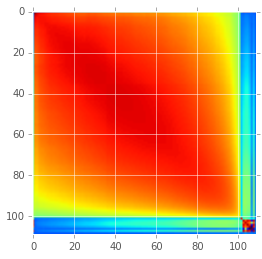

In [325]:
plt.imshow(covariance_matrix)

## 4. Further Processing Light Data

Modelling Light Intensity Distribution as Normal

In [330]:
viirs = viirs_match[:,1:]

In [345]:
viirs_mean = viirs.mean(axis = 1)
viirs_std = viirs.std(axis = 1)
viirs_total = viirs_match[:,0]
viirs_new = np.array([viirs_total, viirs_mean,viirs_std]).T
viirs_new.shape

(908, 3)

In [356]:
combined_data = np.hstack((viirs_new,pop_match,income_match))
combined_data.shape

(908, 10)

In [357]:
combined_data = sklpp.normalize(combined_data,axis=0)

In [358]:
covariance_matrix = np.cov(combined_data.T)

This covariance matrix shows the correlation between the satellite data, the income data and the population data. The first three features are "total light intensity", "mean light intensity" and "standard deviation of the light intensity". The five features after that are the population census data and the last two are "amount of people in poverty" and "median household income".

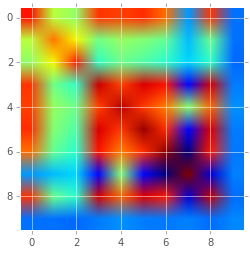

In [366]:
plt.imshow(covariance_matrix)

From the plot we can see that the total light intensity is correlated with some population features as well as with amount of people in poverty. Unfortunately, the data as it stands does not let us see any interesting correlations because the bulk of the variance can be explained away by how many people live in a county.

## 5. Normalizing by Population Variability